# Biodiversity Intactness Index change in Phoenix subdivision

Author: Oksana Protsukha

Repository: https://github.com/oksanaprotsukha/biodiversity_index_phoenix

## Overview

### Project background
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001 [1]. Urban sprawl creates pressure on biodiversity and natural areas. In this analysis we are going to explore a dataset showing values for a biodiversity intactness index (BII) [2, 3] to find changes in this BII around the Phoenix area from 2017 to 2020. 

### Purpose
Analyze the loss in biodeversity within Phoenix subdivision from 2017 to 2020 using raster and vector data.

### Highlights of analysis
- Fetch raster data from the Microsoft Planetary Computer's STAC catalogue
- Visualize raster data 
- Visualize vector data over the basemap
- Perform map algebra
- Time series analysis

### Tools
- Microsoft Planetary Computer's STAC catalogue
- `numpy`
- `pandas`
- `pyplot and patches from matplotlib`
- `xarray`
- `rioxarray`
- `geopandas`
- `contextily`

### Datasets description

- Biodiversity Intactness Index (BII) raster data: this dataset is part of [the MPC STAC catalog](https://planetarycomputer.microsoft.com). I used the ‘io-biodiversity’ collection to extract rasters covering Phoenix subdivision in 2017 and 2020. 
    - Phoenix Subdivision Bounding box: [-112.826843, 32.974108, -111.184387, 33.863574]


- Phoenix subdivision shape file: You will find the Phoenix subdivision polygon in [the Census County Subdivision shapefiles for Arizona](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions)

## Setup

Import all the necessary libraries and packages.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

import planetary_computer
from IPython.display import Image

import pystac_client
import contextily as ctx # for adding basemaps

## Import Data

### Import raster data from MS Planetary computer, 'io-biodiversity' collection

In [2]:
# load collection
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search
search = catalog.search(
    collections=['io-biodiversity'],
    bbox=bbox,
    datetime='2017/2020' # years with 0.6m/pixel resolution; time is inclusive
)

### Import Phoenix subdivision shape file

We can lookup Phoenix subdivision ID (COUSUBFP == '92601') in the [US Census](https://www.census.gov/library/reference/code-lists/ansi.html#cousub).

All meta data details can be found [here](https://www2.census.gov/geo/docs/reference/codes2020/cousub/st04_az_cousub2020.txt).

<Axes: >

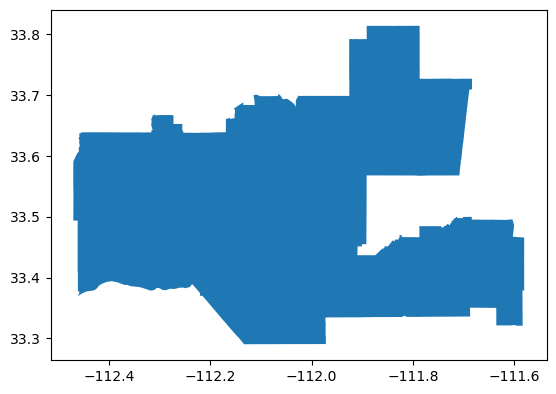

In [3]:
# load shape file
counties = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
counties.head()

# filter counties shape file to Phoenix subdivision
phoenix = counties[counties.COUSUBFP == '92601']
phoenix.plot()

## Retrieve and Explore Rasters Data

In [4]:
# create a dictionary using list comprehension
# for each item in search.items access item.id and assign it to a current item
items = {item.id : item for item in search.items()}

# retrive raster for bii in 2017
bii_2017 = items['bii_2017_34.74464974521749_-115.38597824385106_cog']

# retrive raster for bii in 2020
bii_2020 = items['bii_2020_34.74464974521749_-115.38597824385106_cog']

Text(0.5, 1.0, 'BII 2020')

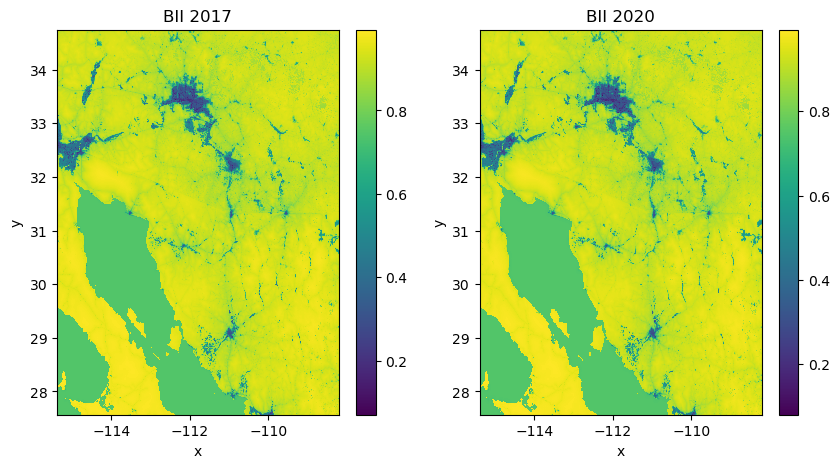

In [5]:
# visualize the rasters with BII data for 2017 and 2020
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

phoenix_2017 = rioxr.open_rasterio(bii_2017.assets['data'].href)
phoenix_2017.sel(band=[1]).plot(ax=ax1)
ax1.set_title("BII 2017")

phoenix_2020 = rioxr.open_rasterio(bii_2020.assets['data'].href)
phoenix_2020.sel(band=[1]).plot(ax=ax2) 
ax2.set_title("BII 2020")

## Geographical  a Map of Phoenix Subdivision

In this step we visualize a map of the Phoenix subdivision within an appropriate geographical context. 
Note: a basemap is created using contextily package.

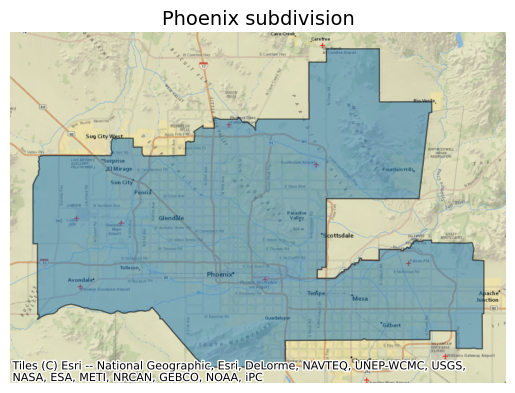

In [6]:
##--------------------------MAP--------------------------
fig, ax = plt.subplots()

(phoenix.to_crs(epsg=3857).
plot(ax=ax, figsize=(7,7), alpha=0.5, edgecolor='k')
)

# add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

ax.set_title('Phoenix subdivision', fontdict={'fontsize':'14'})
ax.set_axis_off()

plt.savefig('images/phoenix_subdivision.png', dpi=300, bbox_inches='tight')
plt.show()

## Map Algebra

In this section we perform map algebra to identify the loss in BII area from 2017 to 2020:

1. Confirm that CRS of raster file with BII data & Phoenix subdivision shape file match.
2. Clip BII raster files to the boundaries of Phoenix subdivision.
3. Create a mask with boolean values of the area that has BII at least 0.75 in 2017 and in 2020.
4. Calculate the percentage of area with BII of at least 0.75 in 2017
5. Calculate the difference in the area that has BII at least at least 0.75 between 2017 and 2020.
6. Exlude the area with BII>=0.75 that was gained in 2020 in comparison to 2017.
7. Make a map of Phoenix subdivision with the area that experienced a loss in BII.

In [7]:
# reproject phoenix shape file to crs of the raster
phoenix_reprojected = phoenix.to_crs(crs = phoenix_2017.rio.crs)

# subset phoenix 
phoenix_2017_clip = phoenix_2017.rio.clip(phoenix_reprojected.geometry)
phoenix_2020_clip = phoenix_2020.rio.clip(phoenix_reprojected.geometry)

In [8]:
# subset area of the Phoenix subdivision to the region with a BII of at least 0.75 in 2017
phoenix_2017_clip_bii = (phoenix_2017_clip >= 0.75).astype(int)
phoenix_2020_clip_bii = (phoenix_2020_clip >= 0.75).astype(int)

print(f'Unique values of Phoenix BII Mask in 2017: {np.unique(phoenix_2017_clip_bii.values)}')
print(f'Unique values of Phoenix BII Mask in 2020: {np.unique(phoenix_2017_clip_bii.values)}')

Unique values of Phoenix BII Mask in 2017: [0 1]
Unique values of Phoenix BII Mask in 2020: [0 1]


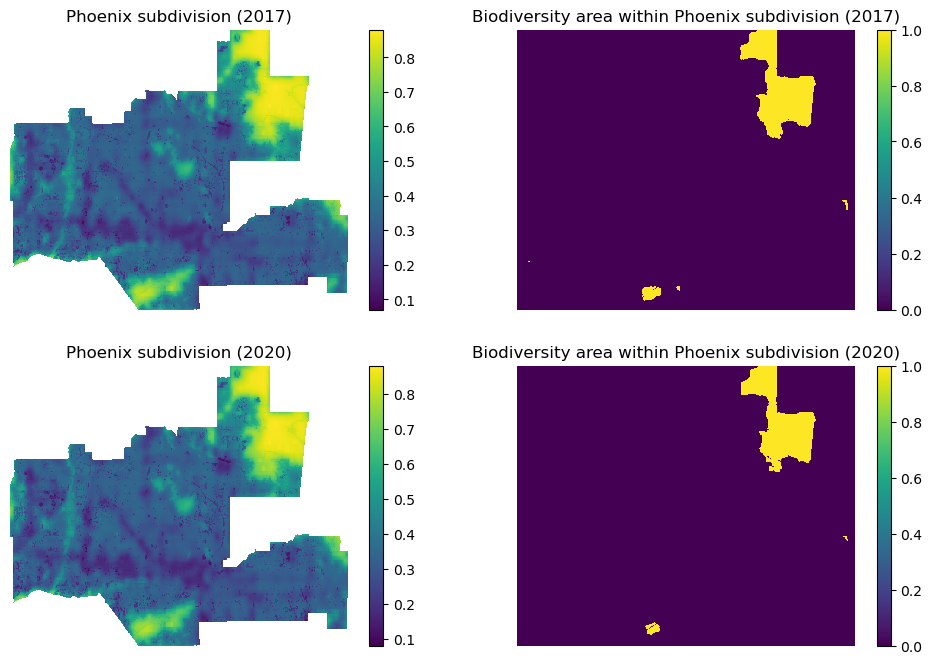

In [9]:
# plot Phoenix subdivision and the area with a BII of at least 0.75 in 2017

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

for ax in [ax1, ax2, ax3, ax4]:
    ax.axis('off')

# plot phoenix_2017_clip on the first subplot (ax1)
phoenix_2017_clip.plot(ax=ax1)
ax1.set_title('Phoenix subdivision (2017)')

# plot phoenix_2017_clip_bii on the second subplot (ax2)
phoenix_2017_clip_bii.plot(ax=ax2)
ax2.set_title('Biodiversity area within Phoenix subdivision (2017)')

# plot phoenix_2020_clip on the first subplot (ax1)
phoenix_2020_clip.plot(ax=ax3)
ax3.set_title('Phoenix subdivision (2020)')

# plot phoenix_2020_clip_bii on the second subplot (ax2)
phoenix_2020_clip_bii.plot(ax=ax4)
ax4.set_title('Biodiversity area within Phoenix subdivision (2020)')

plt.show()

In [10]:
# calculate the percentage of area with BII of at least 0.75 in 2017
# (pixels with BII (value 1))/(total pixels in Phoenix subdivision) * 100
phoenix_2017_clip_bii_pct = (phoenix_2017_clip_bii.sum()/phoenix_2017_clip.count() * 100)
phoenix_2020_clip_bii_pct = (phoenix_2020_clip_bii.sum()/phoenix_2020_clip.count() * 100)

print(f'Percentage of area with BII >=0.75 in 2017: {"{:,.2f}%".format(phoenix_2017_clip_bii_pct.item())}')
print(f'Percentage of area with BII >=0.75 in 2020: {"{:,.2f}%".format(phoenix_2020_clip_bii_pct.item())}')

Percentage of area with BII >=0.75 in 2017: 7.13%
Percentage of area with BII >=0.75 in 2020: 6.49%


In [11]:
# calculate bii area lost between 2017 and 2020
phoenix_bii_diff = (phoenix_2017_clip_bii - phoenix_2020_clip_bii)

# get unique values in the difference raster
print(f'Unique values in the BII difference raster in 2017: {np.unique(phoenix_bii_diff.values)}')

Unique values in the BII difference raster in 2017: [-1  0  1]


**Note**: in our difference raster we have values that account for both gain and loss in BII index from 2017 to 2020.
However, for this analysis we are only interested in the area with BII>=0.75 in 2017 that was **lost** by 2020. 

To exclude the areas with BII>=0.75 that were gained by 2020, we will subset the difference raster to include only pixels that have values equal to 1. 

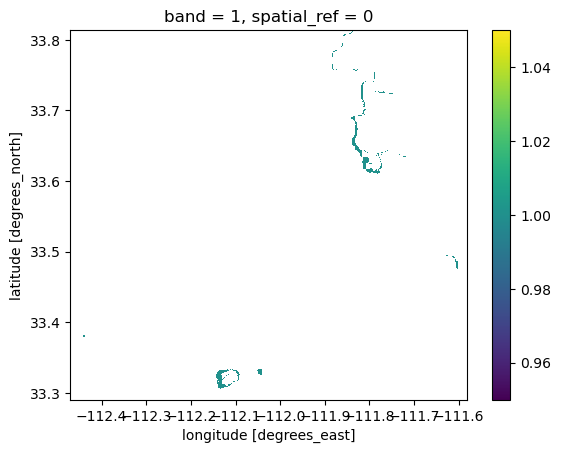

In [12]:
# filter to areas with BII>=0.75 in 2017 that were lost in 2020 (e.g. exclude any areas that were improved)
phoenix_bii_loss = phoenix_bii_diff.where(phoenix_bii_diff == 1)
phoenix_bii_loss.plot()

### Create a Map of BII Loss from 2017 to 2020

NameError: name 'mcolors' is not defined

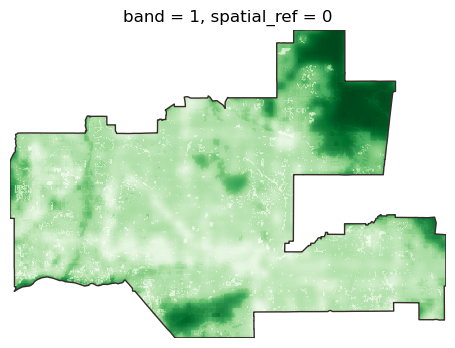

In [13]:
# set the figure size and aspect ratio 
size = 4
aspect = phoenix_2020_clip.rio.width / phoenix_2020_clip.rio.height

fig, ax = plt.subplots()
fig.set_size_inches(size * aspect, size)

ax.axis('off')

# plot phoenix subdivision raster
plot1 = phoenix_2020_clip.plot(ax=ax, cmap='Greens', 
                               label='Phoenix Subdivision', 
                               add_colorbar=False)

# plot phoenix subdivision shapefile
phoenix.plot(ax=ax, color='none', edgecolor = '#372b2b', linewidths = 1)

plot2 = phoenix_bii_loss.plot(ax=ax, 
                              cmap=mcolors.ListedColormap(['red']), 
                              add_colorbar=False)

ax.set_title('Biodiversity Intactness Index (BII) - Phoenix Subdivision')

# create a legend for phoenix_bii_loss
legend2_proxy = mpatches.Patch(color='red', label='Area with BII ≥ 0.75 lost from 2017 to 2020')
ax.legend(handles=[legend2_proxy], 
          loc='lower center', 
          bbox_to_anchor=(0.5, -0.15),
          edgecolor="none")

# create colorbar for phoenix_2020_clip
cbar = plt.colorbar(plot1, ax=ax, orientation='horizontal', fraction=0.07, pad=0.12)
cbar.set_label('2020 BII')

plt.savefig('images/bii_loss.png', dpi=300, bbox_inches='tight')
plt.show()

## Citations

[1] Levitt, Zach, and Jess Eng. “Where America’s Developed Areas Are Growing: ‘Way off into the Horizon.’” Washington Post, https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. Accessed 13 Dec. 2023.
<br>
[2] Levitt, Zach, and Jess Eng. “Where America’s Developed Areas Are Growing: ‘Way off into the Horizon.’” Washington Post, https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. Accessed 13 Dec. 2023.
<br>
[3] Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Accessed 13 Dec. 2023.
